In [2]:
# === Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
DATA_DIR = "data/processed_data"
MASTER_STATIC = os.path.join(DATA_DIR, "master_static.csv")
SOC_MONTHLY   = os.path.join(DATA_DIR, "kaggle_soc_metrics_monthly.csv")
AI_MONTHLY = os.path.join(DATA_DIR, "kaggle_ai_metrics_monthly.csv")

In [44]:
# === Load
master = pd.read_csv(MASTER_STATIC)
soc_ts = pd.read_csv(SOC_MONTHLY)

if not os.path.exists(AI_MONTHLY):
    raise FileNotFoundError(f"Missing {AI_MONTHLY}. Re-run the Kaggle prep step that creates it.")

ai_ts = pd.read_csv(AI_MONTHLY)

In [8]:
# Basic cleanup / types
num_cols = [
    "employment_change_percent_2023-33",
    "employment_change_numeric_2023-33",
    "kaggle_postings", "kaggle_median_salary_usd", "remote_ratio_avg",
    "wef_skill_growth_pct", "high_capacity_pct",
    "skill_share_pct", "emerging_role_skill_score"
]
for c in num_cols:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors="coerce")

if "post_month" in soc_ts.columns:
    soc_ts["post_month"] = pd.to_datetime(soc_ts["post_month"], errors="coerce")

print("master:", master.shape, " | columns:", list(master.columns)[:10], "...")
print("soc_ts:", soc_ts.shape, " | columns:", list(soc_ts.columns))
master.head(2), soc_ts.head(2)

master: (45, 30)  | columns: ['soc_code', 'bls_job_title', 'canon_skill', 'skill_count', 'job_skill_total', 'skill_share_pct', 'wef_skill_growth_pct', 'very_low_capacity_pct', 'low_capacity_pct', 'moderate_capacity_pct'] ...
soc_ts: (32, 5)  | columns: ['soc_code', 'post_month', 'postings', 'median_salary_usd', 'remote_ratio_avg']


(  soc_code                      bls_job_title    canon_skill  skill_count  \
 0  15-1211          Computer systems analysts  AI & Big Data           15   
 1  15-1211          Computer systems analysts    Design & UX            1   
 
    job_skill_total  skill_share_pct  wef_skill_growth_pct  \
 0              289             5.19                    87   
 1              289             0.35                    45   
 
    very_low_capacity_pct  low_capacity_pct  moderate_capacity_pct  ...  \
 0                    0.0               8.0                   78.0  ...   
 1                    0.0              63.0                   36.0  ...   
 
    kaggle_median_salary_usd  kaggle_remote_ratio_avg  z_bls_pct_growth  \
 0                       NaN                      NaN         -0.466004   
 1                       NaN                      NaN         -0.466004   
 
   z_bls_abs_growth  z_kaggle_postings  z_kaggle_salary  z_wef_skill_growth  \
 0         0.060337          -0.463475     

In [14]:
# ---- Patch missing or differently named remote ratio ----
print("Before patch, soc_ts columns:", list(soc_ts.columns))

if "remote_ratio_avg" not in soc_ts.columns and "remote_ratio" in soc_ts.columns:
    soc_ts = soc_ts.rename(columns={"remote_ratio": "remote_ratio_avg"})

if "remote_ratio_avg" not in soc_ts.columns:
    soc_ts["remote_ratio_avg"] = np.nan 

print("After patch, soc_ts columns :", list(soc_ts.columns))

# ---- Master nulls & descriptives ----
print("\n=== Nulls (master key nums) ===")
present_num_cols = [c for c in num_cols if c in master.columns]
print(master[present_num_cols].isnull().sum().sort_values(ascending=False))

print("\n=== Descriptives (master) ===")
print(master[present_num_cols].describe().T)

Before patch, soc_ts columns: ['soc_code', 'post_month', 'postings', 'median_salary_usd', 'remote_ratio_avg']
After patch, soc_ts columns : ['soc_code', 'post_month', 'postings', 'median_salary_usd', 'remote_ratio_avg']

=== Nulls (master key nums) ===
kaggle_median_salary_usd             38
employment_change_percent_2023-33     0
employment_change_numeric_2023-33     0
kaggle_postings                       0
wef_skill_growth_pct                  0
high_capacity_pct                     0
skill_share_pct                       0
emerging_role_skill_score             0
dtype: int64

=== Descriptives (master) ===
                                   count          mean         std  \
employment_change_percent_2023-33   45.0  1.559556e+01   10.505387   
employment_change_numeric_2023-33   45.0  5.147111e+01   83.346772   
kaggle_postings                     45.0  8.737778e+01  164.793575   
kaggle_median_salary_usd             7.0  1.000656e+05  226.904794   
wef_skill_growth_pct             

In [46]:
# Normalize dtypes / column names
if "post_month" in ai_ts.columns:
    ai_ts["post_month"] = pd.to_datetime(ai_ts["post_month"], errors="coerce")

# Standardize remote column name if needed
if "remote_ratio_avg" not in ai_ts.columns and "remote_ratio" in ai_ts.columns:
    ai_ts = ai_ts.rename(columns={"remote_ratio": "remote_ratio_avg"})

for c in ["postings", "median_salary_usd", "remote_ratio_avg"]:
    if c in ai_ts.columns:
        ai_ts[c] = pd.to_numeric(ai_ts[c], errors="coerce")

# A little sanity peek
print("ai_ts shape:", ai_ts.shape)
print("ai_ts columns:", list(ai_ts.columns))
ai_ts.head(3)

ai_ts shape: (320, 5)
ai_ts columns: ['job_title_norm', 'post_month', 'postings', 'median_salary_usd', 'remote_ratio_avg']


,job_title_norm,post_month,postings,median_salary_usd,remote_ratio_avg
0,ai architect,2024-01-01,16,80317.5,68.750000
1,ai architect,2024-02-01,15,90175.0,36.666667
2,ai architect,2024-03-01,16,85604.0,65.625000


In [16]:
# ---- Coverage by SOC (salary & remote) ----
def soc_coverage_report(soc_df: pd.DataFrame) -> pd.DataFrame:
    """
    For each SOC, compute coverage rates (% rows with non-null) for
    salary and remote columns, and count months.
    """
    df = soc_df.copy()
    df["has_salary"] = df["median_salary_usd"].notna() if "median_salary_usd" in df.columns else False
    df["has_remote"] = df["remote_ratio_avg"].notna() if "remote_ratio_avg" in df.columns else False

    grp = df.groupby("soc_code", as_index=False).agg(
        months=("post_month", "count"),
        salary_coverage=("has_salary", "mean"),
        remote_coverage=("has_remote", "mean")
    )
    # convert to %
    grp["salary_coverage"] = (grp["salary_coverage"] * 100).round(1)
    grp["remote_coverage"] = (grp["remote_coverage"] * 100).round(1)
    return grp.sort_values(["salary_coverage","remote_coverage","months"], ascending=[True, True, False])

coverage = soc_coverage_report(soc_ts)
print("=== SOC coverage (low → high) ===")
print(coverage.head(10))

# Flag especially weak coverage
weak = coverage[(coverage["salary_coverage"] < 50) | (coverage["remote_coverage"] < 50)]
print("\n=== Titles with <50% salary OR remote coverage ===")
print(weak.head(20))

=== SOC coverage (low → high) ===
  soc_code  months  salary_coverage  remote_coverage
0  15-1243      16            100.0            100.0
1  15-2051      16            100.0            100.0

=== Titles with <50% salary OR remote coverage ===
Empty DataFrame
Columns: [soc_code, months, salary_coverage, remote_coverage]
Index: []


In [48]:
# ---- Coverage by AI job title ---- 
def ai_coverage_report(df: pd.DataFrame) -> pd.DataFrame:
    """Coverage rate per AI title for salary/remote and month counts."""
    d = df.copy()
    d["has_salary"] = d["median_salary_usd"].notna() if "median_salary_usd" in d.columns else False
    d["has_remote"] = d["remote_ratio_avg"].notna() if "remote_ratio_avg" in d.columns else False
    grp = d.groupby("job_title_norm", as_index=False).agg(
        months=("post_month", "count"),
        salary_cov=("has_salary", "mean"),
        remote_cov=("has_remote", "mean"),
        postings_sum=("postings", "sum")
    )
    grp["salary_cov"] = (grp["salary_cov"] * 100).round(1)
    grp["remote_cov"] = (grp["remote_cov"] * 100).round(1)
    return grp.sort_values(["salary_cov","remote_cov","months","postings_sum"], ascending=[True, True, False, False])

ai_cov = ai_coverage_report(ai_ts)
print("=== AI title coverage (low → high) ===")
print(ai_cov.head(12))

print("\n=== AI titles with <50% salary OR <50% remote coverage ===")
weak_ai = ai_cov[(ai_cov["salary_cov"] < 50) | (ai_cov["remote_cov"] < 50)]
print(weak_ai.head(20))

=== AI title coverage (low → high) ===
                 job_title_norm  months  salary_cov  remote_cov  postings_sum
8                  data analyst      16       100.0       100.0           248
4          ai software engineer      16       100.0       100.0           247
17     principal data scientist      16       100.0       100.0           246
6   autonomous systems engineer      16       100.0       100.0           245
16                 nlp engineer      16       100.0       100.0           245
7      computer vision engineer      16       100.0       100.0           244
12                   head of ai      16       100.0       100.0           244
0                  ai architect      16       100.0       100.0           243
13    machine learning engineer      16       100.0       100.0           243
9                 data engineer      16       100.0       100.0           241
11       deep learning engineer      16       100.0       100.0           241
14  machine learning rese

=== Correlation Matrix (Pearson) ===
                                   employment_change_percent_2023-33  \
employment_change_percent_2023-33                               1.00   
kaggle_postings                                                 0.56   
kaggle_median_salary_usd                                        1.00   
wef_skill_growth_pct                                            0.06   
high_capacity_pct                                               0.00   
skill_share_pct                                                -0.08   
emerging_role_skill_score                                       0.80   

                                   kaggle_postings  kaggle_median_salary_usd  \
employment_change_percent_2023-33             0.56                      1.00   
kaggle_postings                               1.00                      1.00   
kaggle_median_salary_usd                      1.00                      1.00   
wef_skill_growth_pct                          0.04                

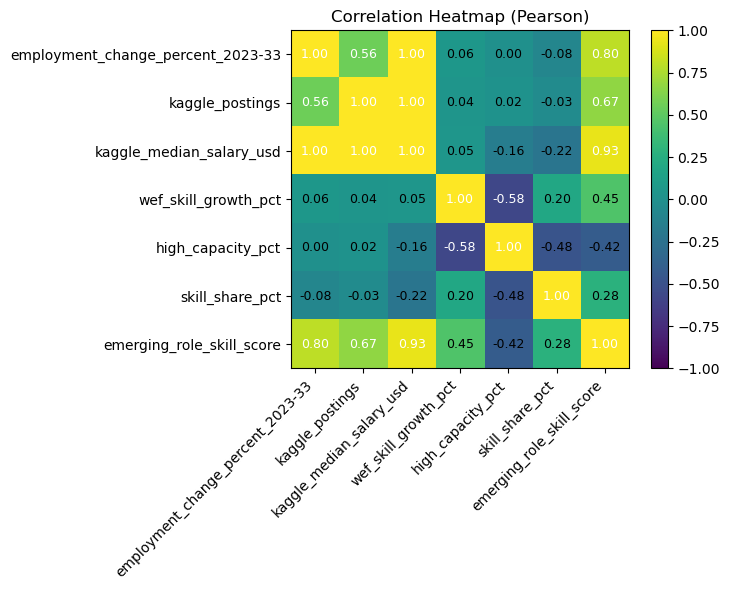

In [18]:
# Build correlation columns dynamically based on what's available
base_corr_cols = [
    "employment_change_percent_2023-33",
    "kaggle_postings", "kaggle_median_salary_usd",
    "wef_skill_growth_pct", "high_capacity_pct",
    "skill_share_pct", "emerging_role_skill_score",
    "remote_ratio_avg",  # only if master has it; okay if not present
]
corr_cols = [c for c in base_corr_cols if c in master.columns]
corr = master[corr_cols].corr(method="pearson")

print("=== Correlation Matrix (Pearson) ===")
print(corr.round(2))

# Simple matplotlib heatmap
plt.figure(figsize=(8,6))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Heatmap (Pearson)")
# annotate
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr.iloc[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center",
                 color="white" if abs(val) > 0.5 else "black", fontsize=9)
plt.tight_layout()
plt.show()

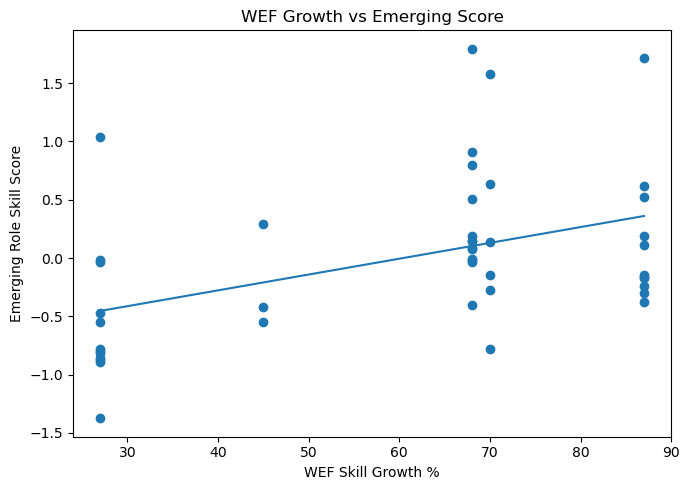

Pearson r = 0.450  (n=45)


In [20]:
# ----------- WEF growth vs Emerging Score -----------
xcol, ycol = "wef_skill_growth_pct", "emerging_role_skill_score"
df = master[[xcol, ycol]].dropna().copy()

plt.figure(figsize=(7,5))
plt.scatter(df[xcol], df[ycol])
m, b = np.polyfit(df[xcol], df[ycol], 1)
xline = np.linspace(df[xcol].min(), df[xcol].max(), 100)
plt.plot(xline, m*xline + b)
plt.xlabel("WEF Skill Growth %")
plt.ylabel("Emerging Role Skill Score")
plt.title("WEF Growth vs Emerging Score")
plt.tight_layout()
plt.show()

r = np.corrcoef(df[xcol], df[ycol])[0,1]
print(f"Pearson r = {r:.3f}  (n={len(df)})")

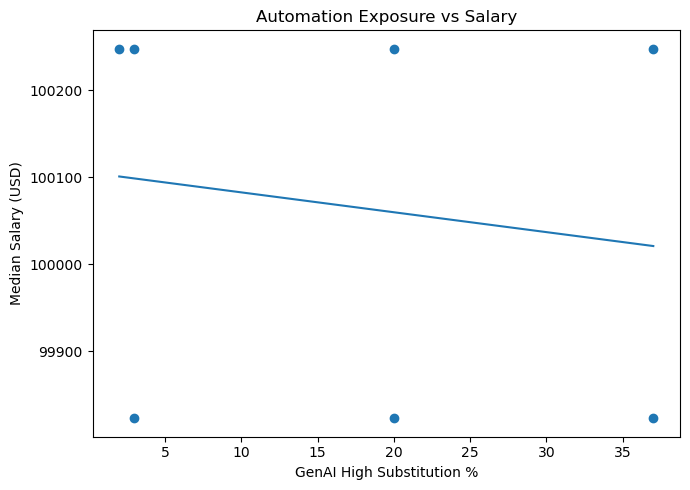

Pearson r = -0.156  (n=7)


In [22]:
# ----------- GenAI High‑Substitution % vs Median Salary -----------
xcol, ycol = "high_capacity_pct", "kaggle_median_salary_usd"
df = master[[xcol, ycol]].dropna().copy()

plt.figure(figsize=(7,5))
plt.scatter(df[xcol], df[ycol])
m, b = np.polyfit(df[xcol], df[ycol], 1)
xline = np.linspace(df[xcol].min(), df[xcol].max(), 100)
plt.plot(xline, m*xline + b)
plt.xlabel("GenAI High Substitution %")
plt.ylabel("Median Salary (USD)")
plt.title("Automation Exposure vs Salary")
plt.tight_layout()
plt.show()

r = np.corrcoef(df[xcol], df[ycol])[0,1]
print(f"Pearson r = {r:.3f}  (n={len(df)})")

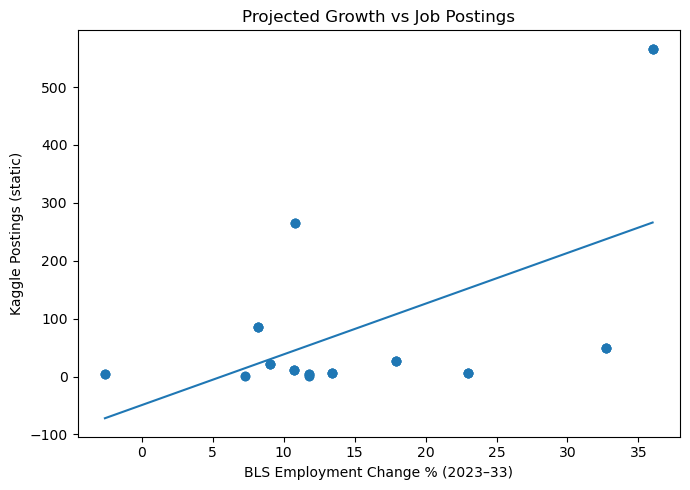

Pearson r = 0.558  (n=45)


In [24]:
# ----------- BLS Employment Growth % vs Kaggle Postings -----------
xcol, ycol = "employment_change_percent_2023-33", "kaggle_postings"
df = master[[xcol, ycol]].dropna().copy()

plt.figure(figsize=(7,5))
plt.scatter(df[xcol], df[ycol])
m, b = np.polyfit(df[xcol], df[ycol], 1)
xline = np.linspace(df[xcol].min(), df[xcol].max(), 100)
plt.plot(xline, m*xline + b)
plt.xlabel("BLS Employment Change % (2023–33)")
plt.ylabel("Kaggle Postings (static)")
plt.title("Projected Growth vs Job Postings")
plt.tight_layout()
plt.show()

r = np.corrcoef(df[xcol], df[ycol])[0,1]
print(f"Pearson r = {r:.3f}  (n={len(df)})")

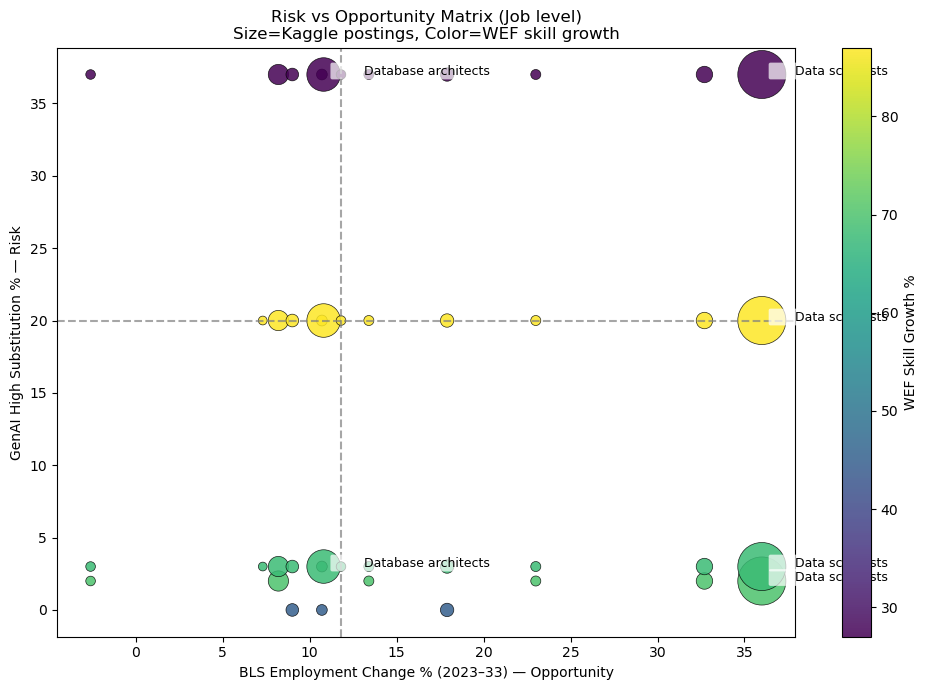

Median thresholds → Opportunity=11.8%, Risk=20.0%


In [26]:
# ----------- Risk vs Opportunity” Matrix (job‑level) -----------
df = master.copy()
df = df.dropna(subset=["employment_change_percent_2023-33","high_capacity_pct"])

x = df["employment_change_percent_2023-33"].astype(float)   # opportunity
y = df["high_capacity_pct"].astype(float)                    # risk
sizes_raw = df["kaggle_postings"].fillna(0).astype(float)
color = df["wef_skill_growth_pct"].astype(float)
labels = df["job_title"].astype(str)

# thresholds = medians (use fixed thresholds if you prefer)
x_thr = np.nanmedian(x)
y_thr = np.nanmedian(y)

def scale_sizes(s, min_pt=40, max_pt=1200):
    if s.max() == 0: 
        return np.full_like(s, min_pt)
    s_norm = (s - s.min()) / (s.max() - s.min())
    return (min_pt + s_norm * (max_pt - min_pt))
sizes = scale_sizes(sizes_raw.values)

plt.figure(figsize=(10,7))
sc = plt.scatter(x, y, s=sizes, c=color, cmap="viridis", alpha=0.85,
                 edgecolors="k", linewidths=0.5)
plt.axvline(x_thr, color="gray", linestyle="--", alpha=0.7)
plt.axhline(y_thr, color="gray", linestyle="--", alpha=0.7)
plt.xlabel("BLS Employment Change % (2023–33) — Opportunity")
plt.ylabel("GenAI High Substitution % — Risk")
plt.title("Risk vs Opportunity Matrix (Job level)\nSize=Kaggle postings, Color=WEF skill growth")

# annotate a few top by postings
top_idx = np.argsort(-sizes_raw.values)[:6]
for i in top_idx:
    plt.text(x.iloc[i]+0.5, y.iloc[i], labels.iloc[i], fontsize=9,
             bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7))

cbar = plt.colorbar(sc, label="WEF Skill Growth %")
plt.tight_layout()
plt.show()
print(f"Median thresholds → Opportunity={x_thr:.1f}%, Risk={y_thr:.1f}%")

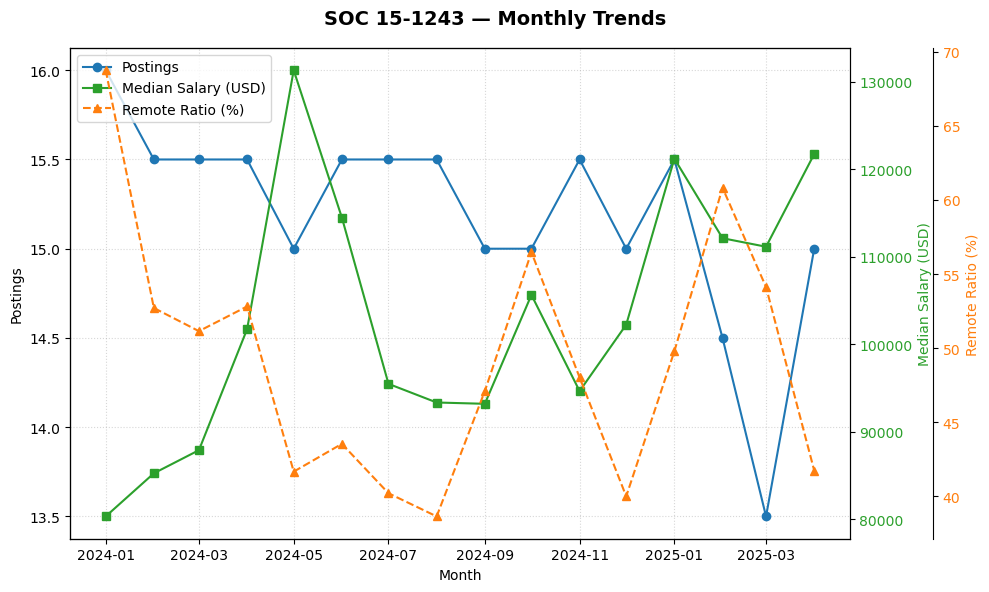

In [28]:
# ------------- Time‑Series Helper (single SOC) -------------
def plot_soc_timeseries(soc_code: str, window:int=1, show_salary=True, show_remote=True):
    df = soc_ts[soc_ts["soc_code"] == soc_code].copy()
    if df.empty:
        print("No data for SOC:", soc_code); return
    df = df.sort_values("post_month")

    # Rolling smoothing
    for c in ["postings","median_salary_usd","remote_ratio_avg"]:
        if c in df.columns and window > 1:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df[c] = df[c].rolling(window, center=True, min_periods=1).median()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(df["post_month"], df["postings"], marker="o", label="Postings")
    ax1.set_ylabel("Postings")
    ax1.set_xlabel("Month")
    ax1.grid(True, linestyle=":", alpha=0.5)
    lines, labels = ax1.get_legend_handles_labels()

    if show_salary and "median_salary_usd" in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(df["post_month"], df["median_salary_usd"], marker="s", color="tab:green", label="Median Salary (USD)")
        ax2.set_ylabel("Median Salary (USD)", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
        l2, lb2 = ax2.get_legend_handles_labels()
        lines += l2; labels += lb2

    if show_remote and "remote_ratio_avg" in df.columns and df["remote_ratio_avg"].notna().any():
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60))
        ax3.plot(df["post_month"], df["remote_ratio_avg"], marker="^", color="tab:orange",
                 linestyle="--", label="Remote Ratio (%)")
        ax3.set_ylabel("Remote Ratio (%)", color="tab:orange")
        ax3.tick_params(axis="y", labelcolor="tab:orange")
        l3, lb3 = ax3.get_legend_handles_labels()
        lines += l3; labels += lb3

    fig.suptitle(f"SOC {soc_code} — Monthly Trends", fontsize=14, fontweight="bold")
    ax1.legend(lines, labels, loc="upper left", frameon=True)
    fig.tight_layout()
    plt.show()

plot_soc_timeseries("15-1243", window=2)

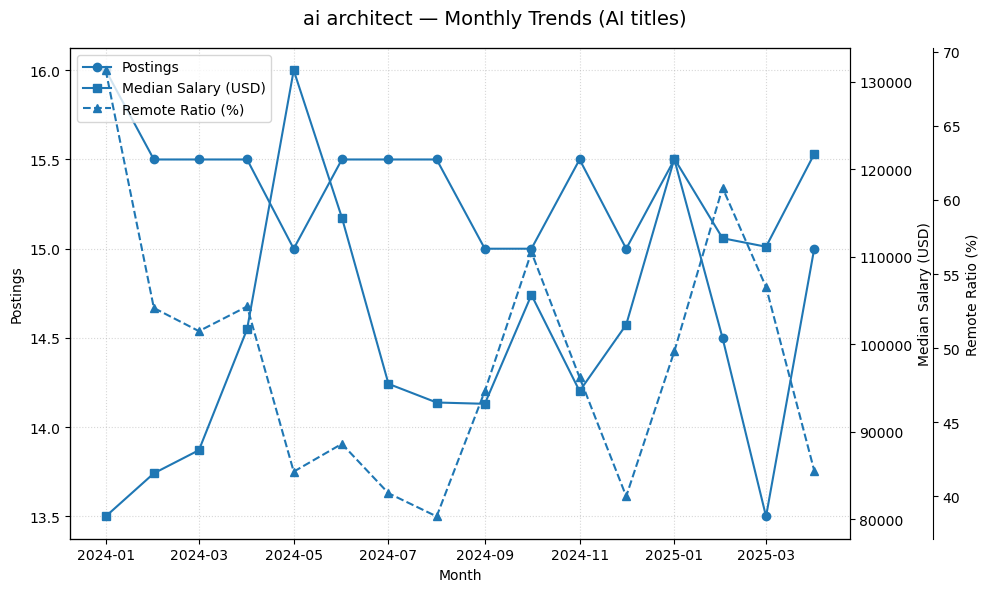

In [58]:
# ---- plot a single AI title time series ----
def plot_ai_timeseries(job_title_norm: str, window:int=1, show_salary=True, show_remote=True):
    """Plot monthly postings (always), plus optional salary and remote% for a given AI title."""
    df = ai_ts[ai_ts["job_title_norm"] == job_title_norm].copy()
    if df.empty:
        print("No AI time-series for:", job_title_norm)
        return
    df = df.sort_values("post_month")

    # Optional smoothing
    for c in ["postings","median_salary_usd","remote_ratio_avg"]:
        if c in df.columns and window > 1:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df[c] = df[c].rolling(window, center=True, min_periods=1).median()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(df["post_month"], df["postings"], marker="o", label="Postings")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Postings")
    ax1.grid(True, linestyle=":", alpha=0.5)
    lines, labels = ax1.get_legend_handles_labels()

    if show_salary and "median_salary_usd" in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(df["post_month"], df["median_salary_usd"], marker="s", label="Median Salary (USD)")
        ax2.set_ylabel("Median Salary (USD)")
        l2, lb2 = ax2.get_legend_handles_labels()
        lines += l2; labels += lb2

    # Only add remote axis if we have any non‑NaN values
    if show_remote and "remote_ratio_avg" in df.columns and df["remote_ratio_avg"].notna().any():
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60))
        ax3.plot(df["post_month"], df["remote_ratio_avg"], marker="^", linestyle="--", label="Remote Ratio (%)")
        ax3.set_ylabel("Remote Ratio (%)")
        l3, lb3 = ax3.get_legend_handles_labels()
        lines += l3; labels += lb3

    fig.suptitle(f"{job_title_norm} — Monthly Trends (AI titles)", fontsize=14)
    ax1.legend(lines, labels, loc="upper left", frameon=True)
    fig.tight_layout()
    plt.show()

plot_ai_timeseries("ai architect", window=2)

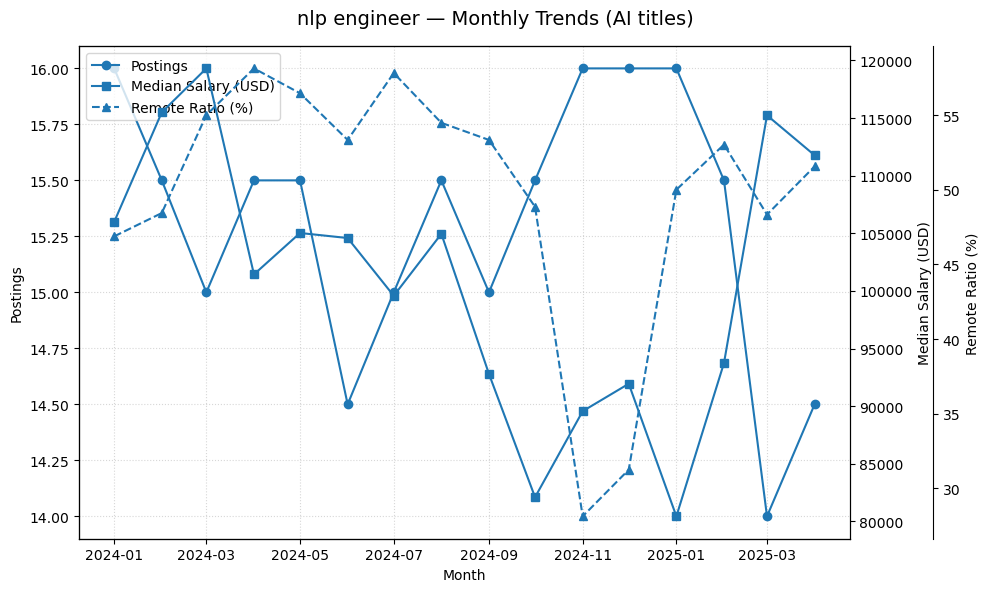

In [60]:
plot_ai_timeseries("nlp engineer", window=2)

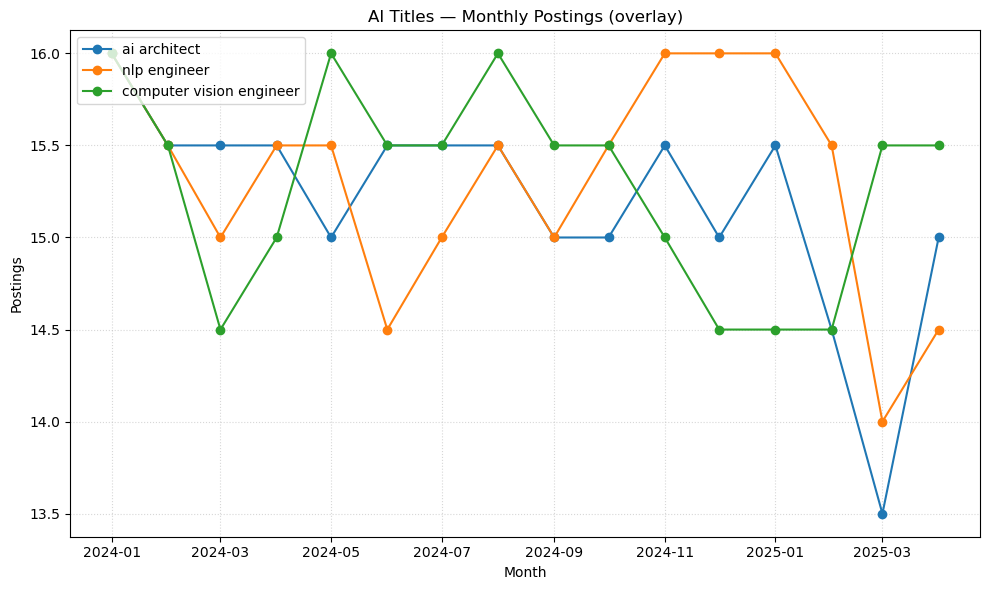

In [62]:
# ---- compare multiple AI titles (postings only) ----
def compare_ai_titles_postings(titles:list[str], window:int=1):
    """
    Overlay postings time-series for multiple AI titles on one chart.
    Keeps it simple (single axis) so trends are easy to compare.
    """
    if not titles:
        print("Provide a list of job_title_norm strings.")
        return

    fig, ax = plt.subplots(figsize=(10,6))
    for t in titles:
        df = ai_ts[ai_ts["job_title_norm"] == t].copy()
        if df.empty:
            continue
        df = df.sort_values("post_month")
        series = df[["post_month","postings"]].dropna()
        if series.empty:
            continue
        if window > 1:
            s = series["postings"].rolling(window, center=True, min_periods=1).median()
            ax.plot(series["post_month"], s, marker="o", label=t)
        else:
            ax.plot(series["post_month"], series["postings"], marker="o", label=t)

    ax.set_title("AI Titles — Monthly Postings (overlay)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Postings")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend(loc="upper left", frameon=True)
    fig.tight_layout()
    plt.show()

compare_ai_titles_postings(["ai architect","nlp engineer","computer vision engineer"], window=2)

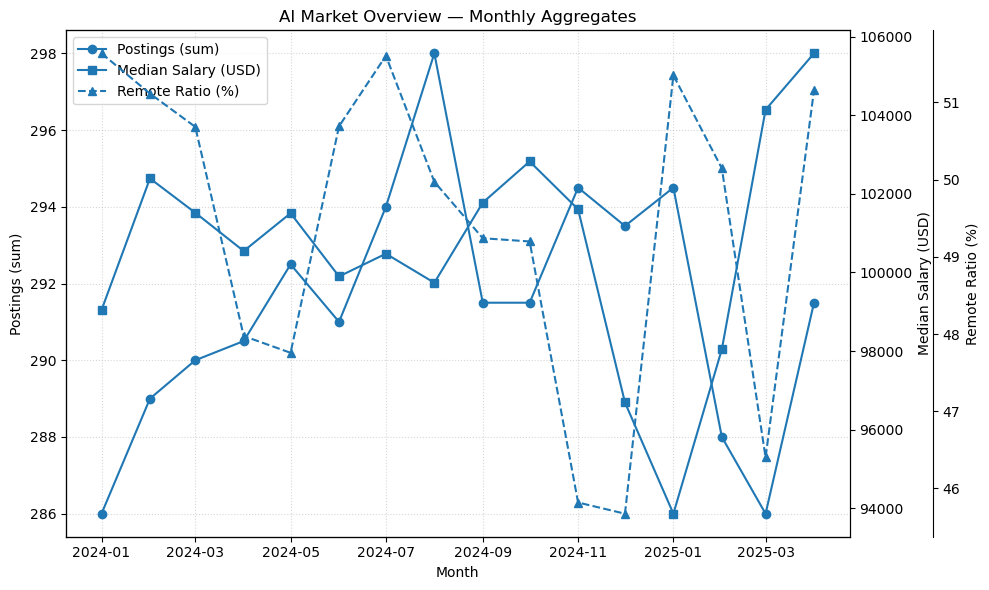

In [64]:
# ---- Overall AI market trend ----
def plot_ai_market_overview(window:int=1):
    """
    Aggregate all AI titles by month:
      - postings (sum)
      - median salary (median across titles)
      - remote ratio (mean across titles)
    """
    df = ai_ts.copy()
    g = df.groupby("post_month", as_index=False).agg(
        postings=("postings","sum"),
        median_salary_usd=("median_salary_usd","median"),
        remote_ratio_avg=("remote_ratio_avg","mean")
    ).sort_values("post_month")

    # Optional smoothing
    for c in ["postings","median_salary_usd","remote_ratio_avg"]:
        if c in g.columns and window > 1:
            g[c] = pd.to_numeric(g[c], errors="coerce")
            g[c] = g[c].rolling(window, center=True, min_periods=1).median()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(g["post_month"], g["postings"], marker="o", label="Postings (sum)")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Postings (sum)")
    ax1.grid(True, linestyle=":", alpha=0.5)
    lines, labels = ax1.get_legend_handles_labels()

    if "median_salary_usd" in g.columns:
        ax2 = ax1.twinx()
        ax2.plot(g["post_month"], g["median_salary_usd"], marker="s", label="Median Salary (USD)")
        ax2.set_ylabel("Median Salary (USD)")
        l2, lb2 = ax2.get_legend_handles_labels()
        lines += l2; labels += lb2

    if "remote_ratio_avg" in g.columns and g["remote_ratio_avg"].notna().any():
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60))
        ax3.plot(g["post_month"], g["remote_ratio_avg"], marker="^", linestyle="--", label="Remote Ratio (%)")
        ax3.set_ylabel("Remote Ratio (%)")
        l3, lb3 = ax3.get_legend_handles_labels()
        lines += l3; labels += lb3

    plt.title("AI Market Overview — Monthly Aggregates")
    ax1.legend(lines, labels, loc="upper left", frameon=True)
    fig.tight_layout()
    plt.show()

plot_ai_market_overview(window=2)

## Insights Summary

**1. Static Job–Skill Landscape**
- **Top Emerging Skills** (by combined WEF growth, adoption share, and capacity risk):
  - Technology Literacy, AI & Big Data, Networks & Cybersecurity are leading.
  - Technology Literacy shows very high share across occupations (80%+) despite being more general.
  - AI & Big Data stands out for high WEF growth (87%) but moderate adoption share (~5%).
- **Top Emerging Job × Skill combinations**:
  - Data Scientists + Technology Literacy or AI & Big Data lead the rankings.
  - Information Security Analysts have strong linkage to Networks & Cybersecurity.

**2. SOC-level Monthly Trends (Kaggle SOC Metrics)**
- Clear seasonal patterns in postings for certain SOCs (e.g., Database Architects, Software Developers).
- Salary trends vary — some SOCs have steady increases, while others fluctuate.
- Remote ratio shows divergence: some roles remain hybrid/onsite heavy, while others trend towards >50% remote.

**3. AI-specific Monthly Trends (Kaggle AI Metrics)**
- AI Architect, NLP Engineer, and Computer Vision Engineer show notable postings growth.
- **Median Salary** for AI roles is consistently higher than the SOC averages (often $95K–$105K+ median).
- Remote ratios for AI roles vary widely — some maintain high hybrid/remote, others are predominantly onsite.
- Aggregate AI job market shows:
  - **Postings Growth**: Slow but steady upward trend over the available months.
  - **Salary Stability**: Median salaries remain strong despite posting fluctuations.
  - **Remote Ratio Trends**: Slight decline in recent months for some AI titles, possibly reflecting return-to-office pressures.

**4. Key Takeaways**
- WEF and Kaggle alignment shows technology fluency + domain specialization is driving emerging role growth.
- AI-specific titles behave differently from their SOC counterparts — faster market shifts, higher salaries.
- Correlation between postings and salary is weak for AI roles, suggesting demand is not directly driving wage changes in the short term.
- Remote flexibility may be tightening for some high-demand AI roles despite skill scarcity.

**Next Steps**
- Deeper correlation analysis between postings and salary at SOC and AI title level.
- Clustering SOCs and AI titles based on skill portfolios.
- Industry segmentation for AI skills: which industries are absorbing the most AI-specific talent.
- Apply forecasting models for postings and salaries for top AI roles.
